## Objetivo do Projeto

O objetivo deste projeto é construir um modelo preditivo capaz de **estimar o valor de venda de imóveis** na cidade de São Paulo, utilizando dados de um dataset público do Kaggle. A predição precisa de preços de imóveis pode ser extremamente útil para **compradores, vendedores e investidores** que desejam avaliar o mercado imobiliário de forma mais precisa.

### Abordagem

Nossa abordagem para resolver esse problema será baseada na aplicação de **algoritmos de regressão**, como Regressão Linear, Random Forest e XGBoost, que são adequados para prever valores contínuos. 

Antes de iniciar a modelagem, realizamos uma **análise exploratória de dados (EDA)** para entender melhor o comportamento das variáveis, identificar valores faltantes, outliers e outras possíveis inconsistências. Com base na EDA, ajustaremos os dados e utilizaremos técnicas de otimização como **Grid Search** para garantir a melhor performance dos modelos.

### Etapas
1. **Análise Exploratória de Dados (EDA)**: Explorar as variáveis e entender sua relação com o preço de venda.
2. **Pré-processamento**: Lidar com valores ausentes e aplicar transformação de variáveis categóricas.
3. **Modelagem**: Aplicar diferentes algoritmos de regressão e otimizar seus parâmetros.
4. **Avaliação de Desempenho**: Avaliar os modelos utilizando métricas como **RMSE** e **R²**.
5. **Aplicação em Produção**: O modelo com melhor desempenho será implementado em uma aplicação **Streamlit** para prever os valores de imóveis na cidade de São Paulo.



## libs

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

## utils

Para facilitar a análise exploratória dos dados e a remoção de outliers, foram criadas duas funções: **identify_outliers** e **plot_graphs**. Estas funções ajudam a identificar os outliers em uma coluna específica de acordo com uma categoria e a gerar gráficos variados (histogramas, boxplots, etc.) com ou sem a remoção de outliers.

In [2]:
def identify_outliers(df_in, column, category='tipo_imovel'):
    df = df_in.copy()

    if 'is_outlier' not in df.columns:
        df['is_outlier'] = False

    for cat in df[category].unique():
        subset = df[df[category] == cat]

        quartile_1 = subset[column].quantile(0.25)
        quartile_3 = subset[column].quantile(0.75)

        interquartile_range = quartile_3 - quartile_1
        
        # Define the lower and upper bounds for outliers
        lower_bound = quartile_1 - 1.5 * interquartile_range
        upper_bound = quartile_3 + 1.5 * interquartile_range

        df.loc[subset[column].index, 'is_outlier'] = df.loc[subset[column].index, 'is_outlier'] | \
            (subset[column] < lower_bound) | (subset[column] > upper_bound)
    
    return df


def plot_graphs(df_in, columns, plot_type='histogram', filter_outliers=False):
    df = df_in.copy()

    color='gray'
    num_columns = len(columns)
    num_rows = math.ceil(num_columns / 3)

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 3 * num_rows))
    sns.set_theme(style="whitegrid") 
    
    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, col in enumerate(columns):
        r = i // 3 
        c = i % 3 

        if filter_outliers:
            df_filtered = identify_outliers(df_in, col).query('is_outlier == False')
        else:
            df_filtered = df

        if plot_type == 'regplot':
            sns.regplot(x='area_util', y='preco_venda', color=color, data=df)
            axes[r, c].title(f'Regression Plot between size and price:{type}')
            axes[r, c].yaxis.set_tick_params(labelsize=7)
            axes[r, c].xaxis.set_tick_params(labelsize=7)
            
        if plot_type == 'histogram':
            sns.histplot(df_filtered[col], bins=60, kde=True, ax=axes[r, c], 
                         color=color, edgecolor='black')
            axes[r, c].set_ylabel('Frequência')
            axes[r, c].yaxis.set_tick_params(labelsize=7)
            axes[r, c].xaxis.set_tick_params(labelsize=7)
            axes[r, c].set_title(f'{plot_type} | {col}', fontsize=10)
            axes[r, c].set_xlabel(None)

        elif plot_type == 'boxplot':
            sns.boxplot(x=df_filtered[col], color=color, ax=axes[r, c])
            axes[r, c].set_xlabel(None)
            axes[r, c].yaxis.set_tick_params(labelsize=7)
            axes[r, c].xaxis.set_tick_params(labelsize=7)
            axes[r, c].set_title(f'{plot_type} | {col}', fontsize=10)

        elif plot_type == 'barplot':
            frequency = df_filtered[col].value_counts().nlargest(10)
            bars = sns.barplot(x=frequency.index, y=frequency.values, color=color, ax=axes[r, c])
            axes[r, c].set_title(f'Distribuição de Valores: ({col})', fontsize=10)
            # axes[r, c].set_ylabel('Frequência')
            axes[r, c].yaxis.set_tick_params(labelsize=7)
            axes[r, c].xaxis.set_tick_params(labelsize=7, rotation=45)
            axes[r, c].set_xlabel(None)

            # labels
            for bar in bars.patches:
                axes[r, c].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                                        f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=7)
        sns.despine(ax=axes[r, c])


    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes[j // 3, j % 3])


    plt.tight_layout()
    plt.show()


def grouping(df_in, cols):
    result = pd.DataFrame()

    for col in cols:        
        df = df_in.groupby([col]).size().reset_index(name='Contagem')
        df['Percentual (%)'] = (df['Contagem'] / df['Contagem'].sum()) * 100
        df_sorted = df.sort_values('Percentual (%)', ascending=False).head(10)
        df_sorted['z'] = '||'
        
        df_sorted.columns = [f'{col}', f'Contagem', f'Percentual(%)', f'||']
        result = pd.concat([result, df_sorted.reset_index(drop=True)], axis=1)

        result.fillna("", inplace=True)

    display(result.reset_index(level=0, drop=True) )


## Coleta de Dados

Para a coleta de dados, foi desenvolvido o script `download_data.py`, com o objetivo de automatizar o processo de extração. Esse script utiliza a API do Kaggle para realizar o download do dataset [House Prices of São Paulo City](https://www.kaggle.com/datasets/ex0ticone/house-prices-of-sao-paulo-city), que contém informações sobre preços de casas para venda e aluguel na cidade de São Paulo, abrangendo listagens de 2011 a 2019. O dataset é salvo dentro da pasta `data/raw` com nome `housing_sp_city.csv`.

### Pré-requisitos

Para executar o script, é necessário:

1. **Conta no Kaggle**: Crie uma conta em [kaggle.com](https://www.kaggle.com/).
2. **Instalar a biblioteca Kaggle**: Execute o seguinte comando no terminal para instalar a biblioteca:

    ```bash
    pip install kaggle
    ```

3. **Configurar a API do Kaggle**:
    - Acesse [My Account](https://www.kaggle.com/account) e crie um token de API para baixar o arquivo `kaggle.json`.
    - Mova o arquivo `kaggle.json` para o diretório:
        - **Linux/Mac**: `~/.kaggle/kaggle.json`
        - **Windows**: `C:\Users\<SeuUsuário>\.kaggle\kaggle.json`
    - Verifique as permissões (Linux/Mac: `chmod 600 ~/.kaggle/kaggle.json`).

4. **Executar o script**: Com os pré-requisitos configurados, execute o script:

    ```bash
    python ../src/download_data.py
    ```

### Script
O que este script faz:
- Baixa o dataset do Kaggle: Ele utiliza a API do Kaggle para fazer o download do dataset "House Prices of São Paulo City".
- Verifica se o download foi bem-sucedido: O script checa se o arquivo .zip foi baixado com sucesso.
- Descompacta o dataset: Após o download, ele extrai os arquivos contidos no .zip para um diretório chamado data.

Esse processo automatiza o download e a extração dos dados do Kaggle para uso no projeto.

In [3]:
!python ../src/download_data.py

Dataset URL: https://www.kaggle.com/datasets/ex0ticone/house-prices-of-sao-paulo-city
License(s): CC-BY-NC-SA-4.0
house-prices-of-sao-paulo-city.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset baixado com sucesso!
Dataset extraído para o diretório 'data/raw'.


## Visão Geral dos Dados 
   Inicialmente, será feito o carregamento do dataset e uma visão geral das variáveis.

### Descrição das Colunas
- **`logradouro`**: Nome da rua ou avenida onde o imóvel está localizado.
- **`numero`**: Número do imóvel na respectiva via.
- **`bairro`**: Nome do bairro onde o imóvel se encontra.
- **`cep`**: Código de Endereçamento Postal (CEP) do imóvel.
- **`cidade`**: Nome da cidade onde o imóvel está localizado (todos os registros são de São Paulo).
- **`tipo_imovel`**: Tipo de imóvel (ex: casa, apartamento, terreno).
- **`area_util`**: Área útil do imóvel, em metros quadrados.
- **`banheiros`**: Quantidade de banheiros no imóvel.
- **`suites`**: Número de suítes no imóvel.
- **`quartos`**: Quantidade de quartos no imóvel.
- **`vagas_garagem`**: Número de vagas de garagem disponíveis.
- **`anuncio_criado`**: Data de criação do anúncio do imóvel.
- **`tipo_anuncio`**: Indica se o anúncio é para venda ou aluguel.
- **`preco_venda`**: Valor de venda do imóvel, em reais.
- **`taxa_condominio`**: Valor da taxa de condomínio mensal, em reais (quando aplicável).
- **`periodicidade`**: Periodicidade de pagamento (geralmente relacionada ao aluguel ou IPTU).
- **`preco_aluguel`**: Valor do aluguel mensal do imóvel, em reais (quando aplicável).
- **`iptu_ano`**: Valor do IPTU anual, em reais.

O dataset possui **133.964 linhas** e **18 colunas**, contendo informações detalhadas sobre imóveis para venda e locação na cidade de São Paulo. Os dados abrangem anúncios criados entre **09 de março de 2011** e **25 de fevereiro de 2019**, fornecendo um amplo histórico do mercado imobiliário da cidade. Comtem **10 colunas numéricas** e **8 colunas não-numéricas**

In [4]:
with open('../data/raw/housing_sp_city.csv', 'r', encoding='utf-8', errors='ignore') as f:
    housing_sp_city = pd.read_csv(f)

housing_sp_city.head(3)

,logradouro,numero,bairro,cep,cidade,tipo_imovel,area_util,banheiros,suites,quartos,vagas_garagem,anuncio_criado,tipo_anuncio,preco_venda,taxa_condominio,periodicidade,preco_aluguel,iptu_ano
0,Rua Juvenal Galeno,53,Jardim da Saúde,4290030.0,São Paulo,Casa de dois andares,388.0,3.0,1.0,4.0,6.0,2017-02-07,Venda,700000,NaN,NaN,NaN,NaN
1,Rua Juruaba,16,Vila Santa Teresa (Zona Sul),4187320.0,São Paulo,Casa,129.0,2.0,1.0,3.0,2.0,2016-03-21,Venda,336000,NaN,NaN,NaN,NaN
2,Avenida Paulista,402,Bela Vista,1311000.0,São Paulo,Comercial,396.0,4.0,0.0,0.0,5.0,2018-12-18,Locação,24929,4900.0,MONTHLY,29829.0,4040.0


**Observação:** Há um erro de codificação na última linha do arquivo CSV, o que impede sua leitura correta utilizando a função pandas.read_csv(). Para solucionar esse problema, optamos por abrir o arquivo manualmente com a função open(), usando a opção errors='ignore' para ignorar eventuais erros de codificação. Esse procedimento permite que o arquivo seja lido corretamente, sem a necessidade de remover manualmente a linha problemática ou modificar o arquivo original.

In [5]:
housing_sp_city.shape

(133964, 18)

In [6]:
housing_sp_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133964 entries, 0 to 133963
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   logradouro       126962 non-null  object 
 1   numero           89823 non-null   object 
 2   bairro           133943 non-null  object 
 3   cep              128056 non-null  float64
 4   cidade           133964 non-null  object 
 5   tipo_imovel      133964 non-null  object 
 6   area_util        130868 non-null  float64
 7   banheiros        133051 non-null  float64
 8   suites           120347 non-null  float64
 9   quartos          130945 non-null  float64
 10  vagas_garagem    129539 non-null  float64
 11  anuncio_criado   133964 non-null  object 
 12  tipo_anuncio     133964 non-null  object 
 13  preco_venda      133964 non-null  int64  
 14  taxa_condominio  117127 non-null  float64
 15  periodicidade    29051 non-null   object 
 16  preco_aluguel    28714 non-null   floa

In [7]:
numerics_types = ['int16', 'int32', 'int64', 'float16','float32','float64']
numerics_variables = housing_sp_city.select_dtypes(include=numerics_types).columns
categorical_variables = housing_sp_city.select_dtypes(exclude=numerics_types).columns
print(f'{len(numerics_variables)} colunas numéricas e {len(categorical_variables)} colunas não-numéricas.')

10 colunas numéricas e 8 colunas não-numéricas.


## Análise Exploratória dos Dados
   Serão realizadas análises descritivas e gráficas para entender o comportamento das variáveis. O objetivo é identificar padrões e possíveis problemas, como a presença de valores ausentes ou inconsistências nos dados, além de avaliar correlações entre as variáveis mais relevantes.

### Verificação de Dados Categóricos

Ao analisar as variáveis categóricas, identificamos alguns pontos que podem impactar o modelo. A variável **cidade** inclui registros de bairros, o que não será um problema, pois essa variável não será utilizada como preditora.

Na variável **tipo_imóvel**, há categorias variadas, como **'Casa de dois andares', 'Casa', 'Comercial', 'Apartamento', 'Flat', 'Cobertura'**, entre outras, gerando um desbalanceamento. Para simplificar, sugerimos filtrar apenas os imóveis residenciais e recategorizá-los em dois grupos: **casas** e **apartamentos**.

Variáveis de pouca relevância, como **cep, logradouro, número, anúncio_criado, taxa_condominio, preco_aluguel, periodicidade** e **iptu_ano**, serão descartadas. Já a variável **bairro** será mantida, pois pode fornecer insights valiosos sobre a localização.

Na variável **tipo_anuncio**, os registros de venda representam **78%** do total. Como o foco é prever o valor de imóveis à venda em São Paulo, os registros de aluguel serão descartados.

Por fim, **174 registros** possuem valores incorretos no campo **cidade** (bairros em vez de cidades). Esses dados serão corrigidos ou removidos nas próximas etapas de tratamento para garantir a consistência.


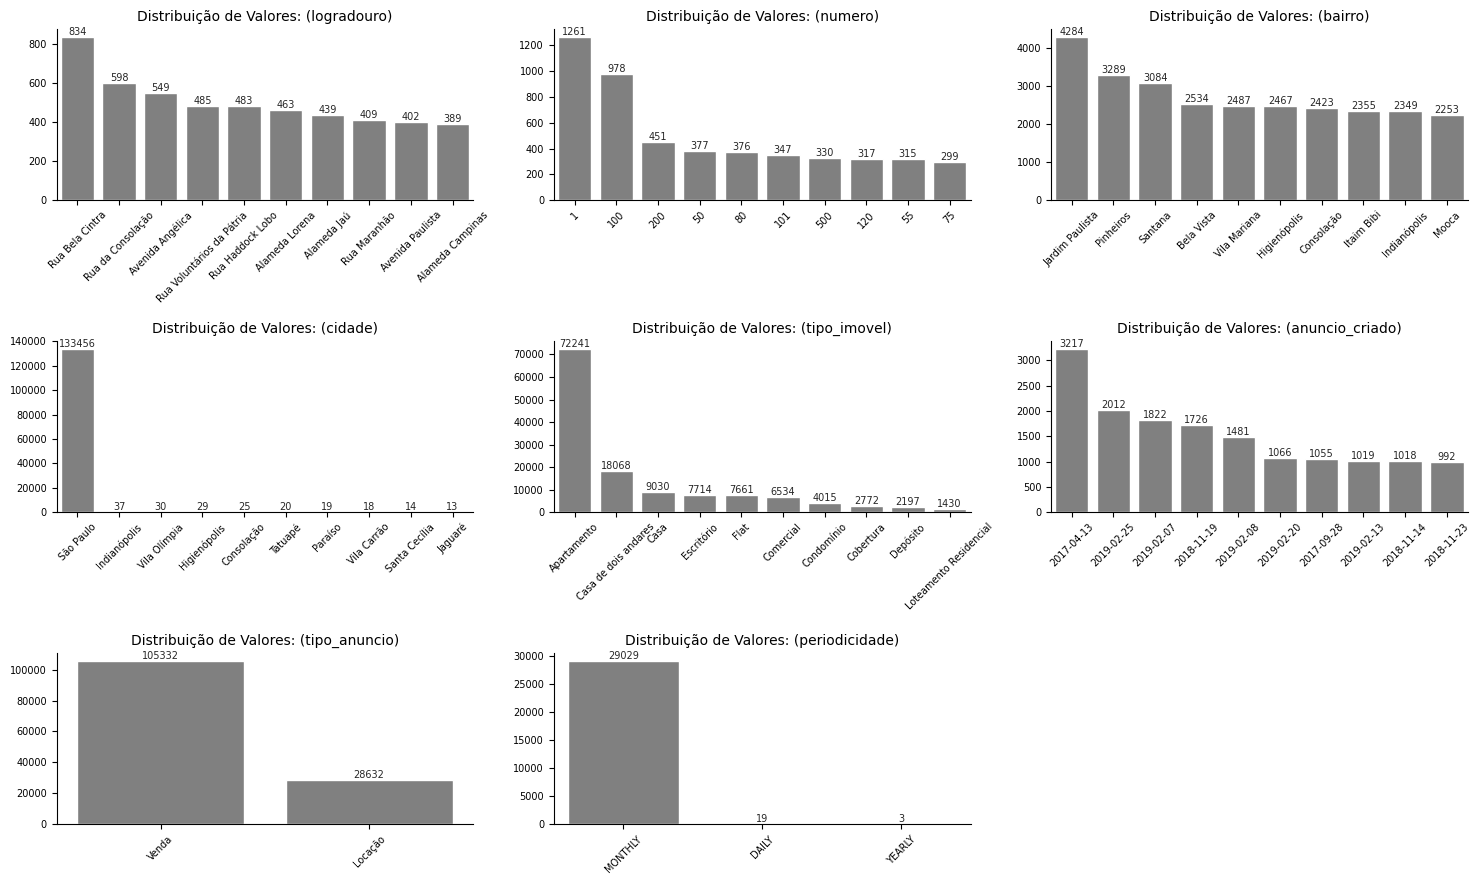

In [8]:
df = housing_sp_city.copy()
plot_graphs(df, categorical_variables, plot_type='barplot')

In [9]:
grouping(housing_sp_city, ['tipo_anuncio', 'tipo_imovel', 'cidade', 'bairro']);

/tmp/ipykernel_1203844/2377123188.py:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.fillna("", inplace=True)


,tipo_anuncio,Contagem,Percentual(%),||,tipo_imovel,Contagem,Percentual(%),||,cidade,Contagem,Percentual(%),||,bairro,Contagem,Percentual(%),||
0,Venda,105332.0,78.627094,||,Apartamento,72241,53.925682,||,São Paulo,133456,99.620794,||,Jardim Paulista,4284,3.198375,||
1,Locação,28632.0,21.372906,||,Casa de dois andares,18068,13.487206,||,Indianópolis,37,0.027619,||,Pinheiros,3289,2.455522,||
2,,,,,Casa,9030,6.740617,||,Vila Olímpia,30,0.022394,||,Santana,3084,2.302472,||
3,,,,,Escritório,7714,5.758263,||,Higienópolis,29,0.021648,||,Bela Vista,2534,1.891850,||
4,,,,,Flat,7661,5.718701,||,Consolação,25,0.018662,||,Vila Mariana,2487,1.856760,||
5,,,,,Comercial,6534,4.877430,||,Tatuapé,20,0.014929,||,Higienópolis,2467,1.841828,||
6,,,,,Condomínio,4015,2.997074,||,Paraíso,19,0.014183,||,Consolação,2423,1.808978,||
7,,,,,Cobertura,2772,2.069213,||,Vila Carrão,18,0.013436,||,Itaim Bibi,2355,1.758211,||
8,,,,,Depósito,2197,1.639993,||,Santa Cecília,14,0.010451,||,Indianópolis,2349,1.753731,||
9,,,,,Loteamento Residencial,1430,1.067451,||,Jaguaré,13,0.009704,||,Mooca,2253,1.682059,||


### Filtragem e Recategorização dos Dados

aplicaremos um filtro para manter apenas os registros do tipo de anúncio de **venda**, pois nosso objetivo é prever o valor dos imóveis na cidade de São Paulo.

In [10]:
# Recategorização da variável 'tipo_imovel'
def recategorize_property_type(df):
    # Mapeamento das categorias
    mapping = {
        'Casa de dois andares': 'Casa',
        'Casa': 'Casa',
        'Comercial': 'Outro',
        'Apartamento': 'Apartamento',
        'Flat': 'Apartamento',
        'Condomínio': 'Outro',
        'Depósito': 'Outro',
        'Loteamento Residencial': 'Outro',
        'Cobertura': 'Apartamento',
        'Loja': 'Outro',
        'Prédio Residencial': 'Apartamento',
        'Escritório': 'Outro',
        'Loteamento Comercial': 'Outro',
        'Kitnet': 'Apartamento',
        'Prédio Comercial': 'Outro',
        'Clínica': 'Outro',
        'Casa de Campo': 'Outro',
        'Fazenda': 'Outro' 
    }

    # Aplicar o mapeamento
    df['tipo_imovel_recategorized'] = df['tipo_imovel'].map(mapping).fillna('Outro')
    
    return df

house_for_sale = housing_sp_city.query('tipo_anuncio == "Venda"').copy()
house_for_sale = house_for_sale[['area_util','banheiros','suites','quartos','vagas_garagem','preco_venda','bairro','tipo_imovel']]
house_for_sale = recategorize_property_type(house_for_sale)

#recalculando os tipo de variaveis
numerics_types = ['int16', 'int32', 'int64', 'float16','float32','float64']
numerics_variables = house_for_sale.select_dtypes(include=numerics_types).columns
categorical_variables = house_for_sale.select_dtypes(exclude=numerics_types).columns
print(f'{len(numerics_variables)} colunas numéricas e {len(categorical_variables)} colunas não-numéricas.')

6 colunas numéricas e 3 colunas não-numéricas.


In [11]:
grouping(house_for_sale, ['tipo_imovel_recategorized']);

,tipo_imovel_recategorized,Contagem,Percentual(%),||
0,Apartamento,69341,65.830897,||
1,Casa,24953,23.689857,||
2,Outro,11038,10.479247,||


### Verificação de Dados Numéricos

A verificação de dados numéricos é uma etapa crucial na preparação dos dados para análise e modelagem. Nessa fase, examinamos as variáveis numéricas do nosso dataset em busca de inconsistências, outliers e padrões que possam influenciar a performance do modelo.

#### Análise descritiva
Ao realizar a análise descritiva do dataset utilizando o método `describe`, observamos que existem várias variáveis com indícios de ruídos, o que pode impactar a qualidade dos dados. 

**`area_util`**, têm uma variabilidade significativa, com um valor mínimo de **1** e um máximo de **2.025.000**, indicando que alguns registros podem conter erros ou outliers.

Além disso, as variáveis relacionadas a **`area_util`**,**`banheiros`**, **`suites`**, **`quartos`** e **`vagas_garagem`** também apresentam valores que podem não ser realistas, como um máximo de **200 banheiros** e **600 quartos**. Esses resultados sugerem que muitos registros podem precisar de revisão.

Esses ruídos devem ser tratados na etapa de tratamento de dados para garantir a integridade e a precisão das análises subsequentes. A limpeza e a validação dos dados são essenciais para aprimorar a qualidade do modelo preditivo que será desenvolvido.

In [12]:
house_for_sale.describe().round(2)

,area_util,banheiros,suites,quartos,vagas_garagem,preco_venda
count,102763.00,104664.00,95627.00,104053.00,102367.00,105332.00
mean,197.26,2.39,1.18,2.55,2.15,841562.35
std,6477.09,1.98,1.22,2.18,2.75,1434908.50
min,1.00,0.00,0.00,0.00,0.00,7000.00
25%,64.00,1.00,0.00,2.00,1.00,296800.00
50%,105.00,2.00,1.00,3.00,2.00,482299.00
75%,182.00,3.00,2.00,3.00,3.00,886900.00
max,2025000.00,200.00,80.00,600.00,414.00,84000000.00


Ao aplicar métodos como boxplots para visualizar a presença de outliers, enfrentamos dificuldades devido à distorção causada por valores extremos. Para melhorar a visualização e facilitar a análise dos dados, decidimos filtrar os outliers nas variáveis numéricas.


### Análise Visual: Boxplots

A análise dos boxplots revela os seguintes pontos:

- **Área Útil**: Grande quantidade de outliers com áreas muito acima da mediana, indicando imóveis maiores e possivelmente de luxo.
- **Banheiros**: A maioria dos imóveis tem até 3 banheiros, mas há outliers com até 15 banheiros, indicando grandes propriedades.
- **Suítes**: Predominância de imóveis com 1 suíte, porém outliers indicam imóveis com até 6 suítes.
- **Quartos**: A maioria dos imóveis tem entre 2 e 3 quartos, com alguns outliers possuindo até 5 quartos.
- **Vagas de Garagem**: A maioria dos imóveis tem até 2 vagas, mas há outliers com até 14 vagas, sugerindo grandes propriedades ou edifícios comerciais.
- **Preço de Venda**: Muitos outliers indicam imóveis de alto padrão com preços bem superiores à mediana.

**Conclusão**: Para variáveis como **preço de venda** e **área útil**, o boxplot revelou a presença de muitos outliers, que indicam imóveis com valores ou áreas muito superiores ao restante do dataset. Esses outliers podem ser tratados ou removidos na etapa de pré-processamento para evitar que prejudiquem a precisão do modelo preditivo.

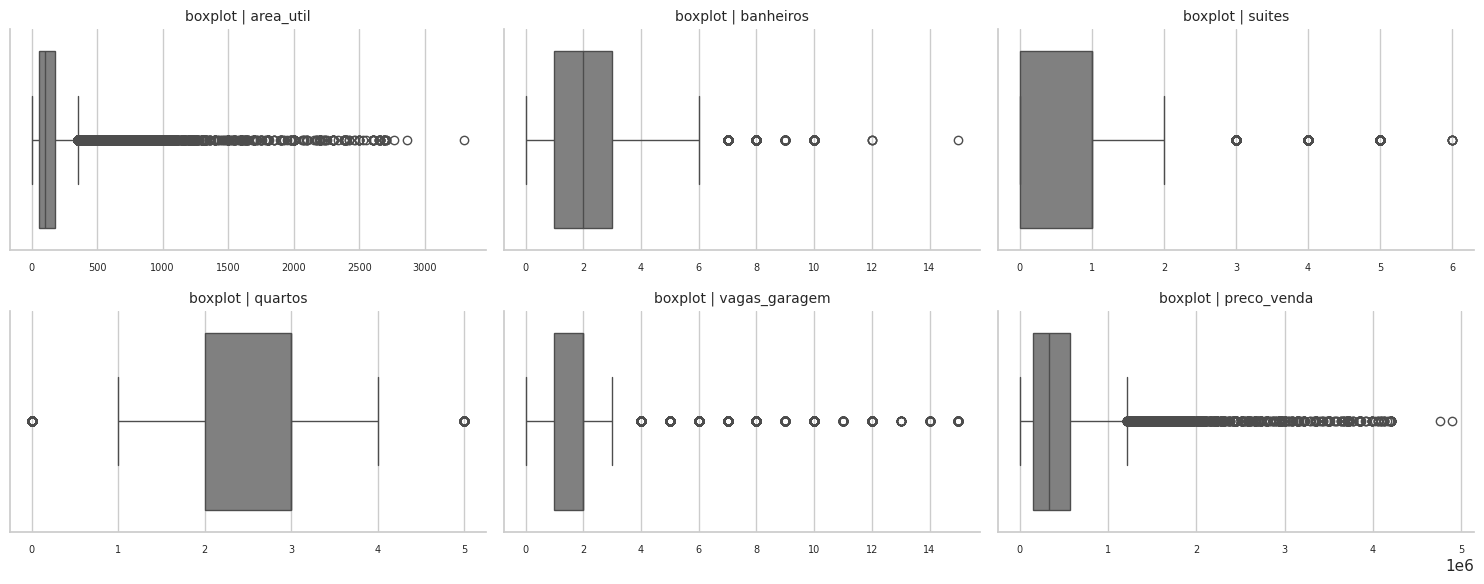

In [13]:
df = housing_sp_city.copy()
plot_graphs(df, numerics_variables, plot_type='boxplot', filter_outliers=True);

### Análise Visual: Histogramas
A partir da análise dos histogramas das variáveis, algumas conclusões podem ser feitas:

- **Área Útil**: A distribuição é assimétrica à direita (cauda longa), com a maioria dos imóveis tendo uma área útil inferior a 200 m². Poucos imóveis têm áreas maiores, indicando a presença de **outliers**.
- **Banheiros**: A maioria dos imóveis possui entre 1 e 3 banheiros, com poucos imóveis tendo mais de 4 banheiros, sugerindo uma concentração em imóveis menores.
- **Suítes**: A maioria dos imóveis não possui suítes ou possui apenas uma. Imóveis com mais de 2 suítes são menos frequentes.
- **Quartos**: A distribuição dos quartos é multimodal, com a maioria dos imóveis possuindo entre 2 e 3 quartos.
- **Vagas de Garagem**: A maioria dos imóveis possui até 2 vagas de garagem. Poucos imóveis têm mais de 3 vagas.
- **Preço de Venda**: O preço de venda tem uma distribuição assimétrica à direita, com a maioria dos imóveis concentrados em faixas de preço mais baixas, e uma pequena quantidade com preços muito altos (**outliers**).

Essas análises sugerem a presença de **outliers** em várias variáveis (como área útil, preço de venda e taxa de condomínio), além de uma concentração de valores em faixas específicas (banheiros, quartos, suítes). Isso pode impactar o comportamento dos modelos preditivos e deve ser considerado no tratamento de dados e transformações para melhorar a performance dos modelos.

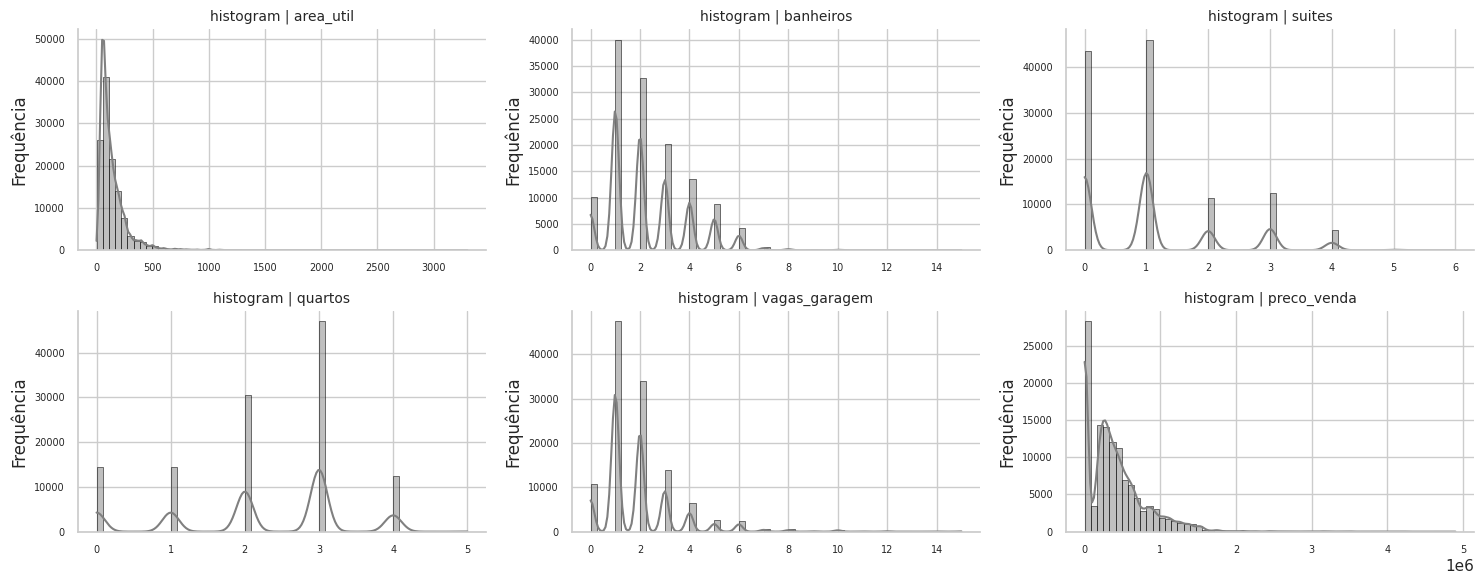

In [14]:
df = housing_sp_city.copy()
plot_graphs(df, numerics_variables, plot_type='histogram', filter_outliers=True)

### Correlação entre Variáveis

Realizamos a análise de correlação entre as variáveis numéricas do dataset para identificar a relação entre as variáveis preditoras e a variável alvo **preço de venda**. 

#### Resultados da Correlação

Ao analisar a correlação entre as variáveis preditoras e o **preço de venda**, observamos que:

- **Área útil** tem a correlação mais alta com o preço de venda (**0.62**), o que faz sentido, já que imóveis maiores tendem a custar mais.
- **Banheiros** e **suítes** também apresentam correlações moderadas (**0.42** e **0.39**, respectivamente), indicando que mais banheiros e suítes aumentam o valor de venda.
- **Quartos** e **vagas de garagem** têm correlações mais baixas (**0.20** e **0.38**, respectivamente), mas ainda podem influenciar o modelo.

#### Impacto na Escolha do Modelo

Esses resultados indicam que variáveis como **área útil**, **banheiros**, e **suítes** devem ser priorizadas no processo de modelagem, pois têm uma relação mais direta com o valor do imóvel. Modelos como **Regressão Linear** podem se beneficiar dessas correlações, uma vez que eles se baseiam em relações lineares entre variáveis. No entanto, também podemos explorar **Random Forest** e **Gradient Boosting**, que conseguem lidar com interações mais complexas entre variáveis, mesmo que suas correlações não sejam tão fortes individualmente.


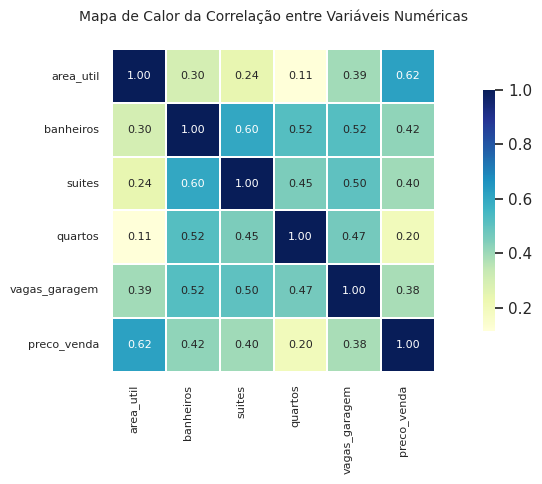

In [15]:
df = house_for_sale.copy()

for col in numerics_variables:
    df =  identify_outliers(df, col, 'tipo_imovel').query('is_outlier == False')

correlation_matrix = df[numerics_variables].corr()

plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap='YlGnBu',square=True, linewidths=0.3,
            cbar_kws={"shrink": 0.75},annot_kws={"size": 8},linecolor='white')  # Cor das linhas entre as células

plt.xticks( ha='right', fontsize=8)
plt.yticks(fontsize=8)

# Título centralizado e com uma fonte mais destacada
plt.title('Mapa de Calor da Correlação entre Variáveis Numéricas', fontsize=10, pad=20)
plt.tight_layout()
plt.show()

### Checagem de Valores Nulos
Ao realizar a checagem de valores nulos, identificamos a presença de valores faltantes em variáveis importantes do dataset, conforme listado abaixo:

- **Área útil**: 2569 valores nulos
- **Banheiros**: 668 valores nulos
- **Suítes**: 9705 valores nulos
- **Quartos**: 1279 valores nulos
- **Vagas de garagem**: 2965 valores nulos

Na próxima etapa de tratamento, optaremos por remover ou substituir esses valores nulos. Para as variáveis **banheiros** e **quartos**, será aplicado um valor fixo de 1, enquanto para **vagas de garagem** e **suítes**, os valores nulos serão preenchidos com 0.

In [16]:
house_for_sale.isnull().sum()

area_util                    2569
banheiros                     668
suites                       9705
quartos                      1279
vagas_garagem                2965
preco_venda                     0
bairro                         15
tipo_imovel                     0
tipo_imovel_recategorized       0
dtype: int64

## Pré-processamento

### Tratamento de Valores Nulos, Dados Inconsistentes, Outliers e Recategorização

Para garantir a qualidade dos dados e otimizar o desempenho do modelo, aplicamos as seguintes estratégias de tratamento:

- **vagas_garagem** e **suites:** Substituímos os valores nulos por **0**, assumindo que a ausência de registro indica que não há essas características no imóvel.
- **quartos** e **banheiros:** Preenchemos os valores nulos com **1**, pois todo imóvel deve conter ao menos um quarto e um banheiro.
- **area_util:** Removemos registros com valores nulos nessa coluna, pois é uma variável fundamental para a análise.
- **bairro:** Eliminamos registros com valores "Desconhecido" para garantir a precisão na identificação da localidade dos imóveis.
- **Registros duplicados:** Foram removidos para evitar inconsistências nos dados.

Além disso, realizamos a **remoção de outliers** nas variáveis numéricas mais relevantes, como **area_util**, **banheiros**, **quartos**, **suites**, **vagas_garagem** e **preco_venda**. A remoção foi feita com base no intervalo interquartil (IQR), ajustando os limites para cada categoria de imóvel.

Também foi aplicada uma **recategorização da variável `tipo_imovel`**, agrupando os imóveis em **"Casa"** e **"Apartamento"**, o que simplifica as categorias e melhora a representatividade dos dados.

Por fim, foi realizada a **seleção das variáveis principais** para a modelagem. Serão utilizadas as seguintes colunas:

- **area_util**
- **banheiros**
- **suites**
- **quartos**
- **vagas_garagem**
- **preco_venda**
- **bairro**
- **tipo_imovel**

Essas ações visam garantir que os dados estejam preparados e otimizados para a etapa de modelagem, utilizando as variáveis mais relevantes e um conjunto de dados limpo e bem categorizado.


In [17]:
_house_for_sale = house_for_sale.copy()

_house_for_sale[['vagas_garagem', 'suites']] = _house_for_sale[['vagas_garagem', 'suites']].fillna(0)
_house_for_sale['bairro'] = _house_for_sale['bairro'].fillna('Desconhecido')

_house_for_sale = _house_for_sale.query('banheiros>0')
_house_for_sale = _house_for_sale.query('quartos>0')
_house_for_sale = _house_for_sale.query('area_util>10')
_house_for_sale = _house_for_sale.query('preco_venda>50000')

_house_for_sale.drop_duplicates(inplace=True)
_house_for_sale = _house_for_sale[['area_util','banheiros','suites','quartos','vagas_garagem','preco_venda','bairro','tipo_imovel']]
_house_for_sale = recategorize_property_type(_house_for_sale)

cols = ['area_util', 'banheiros', 'suites', 'vagas_garagem', 'quartos', 'preco_venda']
for col in cols:
    _house_for_sale =  identify_outliers(_house_for_sale, col, 'tipo_imovel').query('is_outlier == False')

_house_for_sale = _house_for_sale.query('is_outlier == False').drop('is_outlier', axis=1)
_house_for_sale.isnull().sum()

area_util                    0
banheiros                    0
suites                       0
quartos                      0
vagas_garagem                0
preco_venda                  0
bairro                       0
tipo_imovel                  0
tipo_imovel_recategorized    0
dtype: int64

### Verificação Estatística Após o Tratamento dos Dados

Após a aplicação dos tratamentos de dados, realizamos a análise descritiva das principais variáveis numéricas, obtendo um total de 77.399 registros. As medidas de tendência central, como a média e a mediana, bem como a variabilidade dos dados (desvio padrão), estão em conformidade com o esperado, indicando um conjunto de dados preparado para a modelagem.

Além disso, será realizada uma análise de correlação entre as variáveis numéricas para identificar relações que possam ser relevantes no desenvolvimento do modelo preditivo.


In [18]:
_house_for_sale.describe().round(2)

,area_util,banheiros,suites,quartos,vagas_garagem,preco_venda
count,62405.00,62405.00,62405.00,62405.00,62405.00,62405.00
mean,102.29,2.04,0.75,2.45,1.63,470196.90
std,65.29,1.06,0.75,0.74,1.08,320141.83
min,11.00,1.00,0.00,1.00,0.00,53690.00
25%,60.00,1.00,0.00,2.00,1.00,266000.00
50%,82.00,2.00,1.00,3.00,1.00,398300.00
75%,125.00,3.00,1.00,3.00,2.00,581000.00
max,2000.00,8.00,5.00,8.00,10.00,4059999.00


## Salvamento dos Dados Tratados

Após a aplicação do tratamento de valores nulos, correção de dados inconsistentes, remoção ou ajuste de outliers e a recategorização de variáveis, os dados foram preparados para a próxima etapa do projeto. A versão tratada do dataset será salva em formato CSV e utilizada posteriormente na etapa de modelagem.

Esse procedimento garante que as análises e os modelos preditivos sejam construídos com uma base de dados mais limpa e confiável.


In [19]:
_house_for_sale.to_csv('../data/refined/house_for_sale.csv',  sep=",",encoding='utf-8', index_label=False)

-------

## Modelos Preditivos

O projeto de previsão de valores de imóveis na cidade de São Paulo foi dividido em duas abordagens principais: a primeira envolve testes básicos com modelos padrão, e a segunda inclui a otimização desses modelos para maximizar o desempenho. O modelo com o melhor desempenho final será utilizado em uma aplicação em **Streamlit**, permitindo a previsão de valores de imóveis com base nos dados fornecidos.

### Primeira Abordagem: Testes Iniciais com Modelos Padrão

Nesta primeira abordagem, os modelos foram testados sem ajustes nos parâmetros para fornecer uma linha de base de desempenho. As etapas foram as seguintes:

1. **Carregar e preparar os dados**: Carregar o dataset de imóveis e separar a variável alvo (**preço**) das variáveis preditoras (**área, banheiros, etc.**).
2. **Divisão dos dados**: Separação dos dados em treino e teste (80% para treino e 20% para teste).
3. **Pré-processamento**: Aplicação de normalização para variáveis numéricas e codificação **OneHotEncoder** para variáveis categóricas.
4. **Treinamento dos modelos**: Testamos os seguintes modelos:
   - Regressão Linear
   - Random Forest
   - Decision Tree
   - Gradient Boosting
   - XGBoost
5. **Avaliação do desempenho**: Avaliação dos modelos com **RMSE (Root Mean Squared Error)** e **R² (Coeficiente de Determinação)**.

#### Resultados dos Modelos Padrão:

| Modelo                | RMSE            | R²      |
|-----------------------|-----------------|---------|
| Gradient Boosting      | 164052.989137   | 0.752059 |
| Random Forest          | 169647.748049   | 0.734859 |
| XGBoost                | 173882.538574   | 0.721457 |
| Decision Tree          | 204151.893781   | 0.616039 |
| Linear Regression      | 205478.309582   | 0.611033 |


### Segunda Abordagem: Otimização dos Modelos

Nesta segunda abordagem, aplicamos a otimização dos hiperparâmetros para melhorar o desempenho dos modelos. As etapas foram:

1. **Definir os hiperparâmetros**: Especificamos os intervalos de valores para otimizar, como número de estimadores, profundidade máxima da árvore e taxa de aprendizado.
2. **Aplicar GridSearchCV**: Usamos o **GridSearchCV** para testar diferentes combinações de hiperparâmetros e encontrar a melhor configuração.
3. **Treinamento e Avaliação**: Para cada modelo otimizado, repetimos o processo de treinamento e avaliamos o desempenho com **RMSE** e **R²**.
4. **Modelos otimizados**:
   - Random Forest
   - Decision Tree
   - XGBoost
   - Gradient Boosting

#### Resultados dos Modelos Otimizados:

| Modelo                | Melhores Parâmetros                                         | RMSE        | R²    | Fitting                         |
|-----------------------|------------------------------------------------------------|-------------|-------|---------------------------------|
| Random Forest          | {'model__max_depth': 10, 'model__n_estimators': 200}       | 162815.14   | 0.76  | 5 folds para cada um dos 6 candidatos, totalizando 30 fits |
| Decision Tree          | {'model__max_depth': 10, 'model__min_samples_split': 10}   | 176709.09   | 0.71  | 5 folds para cada um dos 18 candidatos, totalizando 90 fits |
| XGBoost                | {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100} | 166203.72   | 0.75  | 5 folds para cada um dos 8 candidatos, totalizando 40 fits |
| Gradient Boosting      | {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100} | 162079.23   | 0.76  | -                               |
| Linear Regression      | N/A                                                        | 205478.31   | 0.61  | -                               |


### Conclusão

Com base nos resultados, o modelo **Gradient Boosting** otimizado apresentou o melhor desempenho geral e será implementado em uma aplicação **Streamlit** para prever os valores de imóveis na cidade de São Paulo, proporcionando uma ferramenta interativa para auxiliar nessa análise.


### Primeira Abordagem: Avaliação Inicial dos Modelos

Nesta primeira abordagem, os modelos foram testados sem ajustes nos parâmetros para fornecer uma linha de base de desempenho. As etapas foram as seguintes:


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

house_for_sale = pd.read_csv('../data/refined/house_for_sale.csv', sep="," )

# Selecionando as variáveis preditoras e o alvo
cols = ['preco_venda', 'area_util', 'banheiros', 'suites', 'quartos', 'vagas_garagem', 'tipo_imovel_recategorized']
df = house_for_sale[cols].copy()

# Separando a variável alvo (preço) das preditoras
X = df.drop('preco_venda', axis=1)
y = df['preco_venda']

# Definindo as colunas numéricas e categóricas
numeric_features = ['area_util', 'banheiros', 'suites', 'quartos', 'vagas_garagem']
categorical_features = ['tipo_imovel_recategorized']

# Criando o pré-processador com OneHotEncoder para categóricas e StandardScaler para numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Normalização das colunas numéricas
        ('cat', OneHotEncoder(), categorical_features)  # OneHotEncoder nas categóricas
    ])

# Dividindo o dataset em conjunto de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criando os modelos
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor(),
}

# Dicionário para armazenar os resultados
results = {}

# Loop pelos modelos e pipeline
for name, model in models.items():
    # Criar pipeline com pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Treinando o modelo
    pipeline.fit(X_train, y_train)
    
    # Fazendo previsões
    y_pred = pipeline.predict(X_test)
    
    # Avaliar o desempenho
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Salvar os resultados
    results[name] = {'RMSE': rmse, 'R²': r2}

results_df = pd.DataFrame(results).T
# Exibir os resultados
print("Modelos ordenados por RMSE:")
results_df.sort_values(by='RMSE', ascending=True)

Modelos ordenados por RMSE:


,RMSE,R²
Gradient Boosting,164052.989137,0.752059
Random Forest,169647.748049,0.734859
XGBoost,173882.538574,0.721457
Decision Tree,204151.893781,0.616039
Linear Regression,205478.309582,0.611033


### Segunda Abordagem: Otimização de Modelos com GridSearchCV

Nesta segunda abordagem, aplicamos a otimização dos hiperparâmetros para melhorar o desempenho dos modelos. As etapas foram:


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1. Carregando os dados
house_for_sale = pd.read_csv('../data/refined/house_for_sale.csv', sep=",")

# 2. Selecionando as variáveis preditoras e o alvo
cols = ['preco_venda', 'area_util', 'banheiros', 'suites', 'quartos', 'vagas_garagem', 'tipo_imovel_recategorized']
df = house_for_sale[cols].copy()

# Separação entre preditoras (X) e alvo (y)
X = df[['area_util', 'banheiros', 'suites', 'quartos', 'vagas_garagem', 'tipo_imovel_recategorized']]
y = df['preco_venda']

# 3. Separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Pipeline de pré-processamento (padronização e OneHotEncoding)
numeric_features = ['area_util', 'banheiros', 'suites', 'quartos', 'vagas_garagem']
categorical_features = ['tipo_imovel_recategorized']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# 5. Definindo os modelos e hiperparâmetros para o GridSearchCV

# Linear Regression (não precisa de hiperparâmetros)
lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('model', LinearRegression())])

# Random Forest
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('model', RandomForestRegressor(random_state=42))])
rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None]
}

# Decision Tree
dt = Pipeline(steps=[('preprocessor', preprocessor),
                     ('model', DecisionTreeRegressor(random_state=42))])
dt_params = {
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 10]
}

# XGBoost
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', XGBRegressor(random_state=42))])
xgb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

# Gradient Boosting
gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', GradientBoostingRegressor(random_state=42))])
gb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1]
}

# 6. Função para executar o GridSearch e avaliar o desempenho
def grid_search_model(model, params, X_train, y_train, X_test, y_test, model_name):
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\nMelhor modelo para {model_name}:")
    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    
    return best_model

# 7. Executando o GridSearchCV para cada modelo

# Random Forest
best_rf = grid_search_model(rf, rf_params, X_train, y_train, X_test, y_test, 'Random Forest')

# Decision Tree
best_dt = grid_search_model(dt, dt_params, X_train, y_train, X_test, y_test, 'Decision Tree')

# XGBoost
best_xgb = grid_search_model(xgb_model, xgb_params, X_train, y_train, X_test, y_test, 'XGBoost')

# Gradient Boosting
best_gb = grid_search_model(gb_model, gb_params, X_train, y_train, X_test, y_test, 'Gradient Boosting')

# 8. Comparando com Linear Regression (não precisa de GridSearchCV)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"\nLinear Regression:\nRMSE: {rmse_lr:.2f}\nR²: {r2_lr:.2f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhor modelo para Random Forest:
Melhores parâmetros: {'model__max_depth': 10, 'model__n_estimators': 200}
RMSE: 162815.14
R²: 0.76
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhor modelo para Decision Tree:
Melhores parâmetros: {'model__max_depth': 10, 'model__min_samples_split': 10}
RMSE: 176709.09
R²: 0.71
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Melhor modelo para XGBoost:
Melhores parâmetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
RMSE: 166203.72
R²: 0.75
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhor modelo para Gradient Boosting:
Melhores parâmetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
RMSE: 162079.23
R²: 0.76

Linear Regression:
RMSE: 205478.31
R²: 0.61


### Salvar melhor modelo

Com base nos resultados, o modelo **Random Forest** otimizado apresentou o melhor desempenho geral e será implementado em uma aplicação **Streamlit** para prever os valores de imóveis na cidade de São Paulo, proporcionando uma ferramenta interativa para auxiliar nessa análise.

In [24]:
import joblib
# Salvar o modelo em um arquivo .pkl
joblib.dump(gb_model, '../models/modelo_imovel_regression.pkl')

['../models/modelo_imovel_regression.pkl']